A Monte Carlo (MC) simulation is one that uses a random number generator in some capacity, and they're sometimes colloquially referred to as "throwing darts". They're used in a wide array of different contexts, but very commonly in physics (which is where I learned of their usefulness). They're great for estimating solutions to very complicated problems that often involve draws from different probability distributions, addressing optimizations which can't be solved analytically, and estimating the sensitivity of a complicated function to varying the input parameters.

I'm writing this blog post to convince you to start playing with your own darts to quickly solve problems and answer common questions. This approach wouldn't have made as much sense 10-20 years ago, but since computing power is so fast and cheap nowadays, you can often use simple MC simulations to get approximate solutions much more quickly than if you had tried to rigorously solve the problem.

### Example 1: Testing the Central Limit Theorem
Let's jump into some examples. Imagine someone tells you that "given a distribution with a mean $\mu$ and variance $\sigma^2$, the sampling distribution of the mean approaches a normal distribution" [[source]](http://davidmlane.com/hyperstat/A14043.html), but you don't believe it because you aren't familiar with the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem). You could try to [rigorously prove it](http://www.cs.toronto.edu/~yuvalf/CLT.pdf) (which is useful to do!), or **you could quickly throw some darts and convince yourself that it's true**.

Let's pick some arbitrary (definitely non-normal) distribution, draw randomly from it a large number of times, compute the mean of each draw, and histogram those means to check if we indeed get a normal distribution. Below I start with a $\chi^2$ distribution with 2 degrees of freedom. I chose this only because it's clearly not normal; the actual distribution is irrelevant.

In [2]:
#ignore
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2
from scipy.stats import norm
import random

import geopandas as gpd
import shapely
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import cascaded_union
import mplleaflet
from shapely.geometry import Point

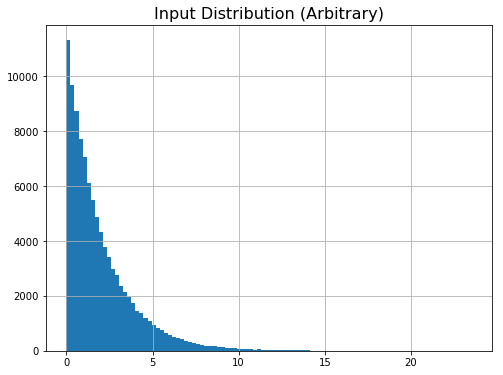

In [3]:
df, N = 2, 100000
plt.figure(figsize=(8,6));
plt.hist(chi2.rvs(df, size=N),bins=100);
plt.grid(True);
plt.title('Input Distribution (Arbitrary)',fontsize=16);

Clearly this distribution is not normal. Let's create this distribution 10,000 times (each time seeded with a different random number "dart", so we aren't re-creating an identical distribution over and over again), and each time let's compute the mean of that distribution.

In [4]:
means = [np.mean(chi2.rvs(df,size=N)) for x in range(10000)]

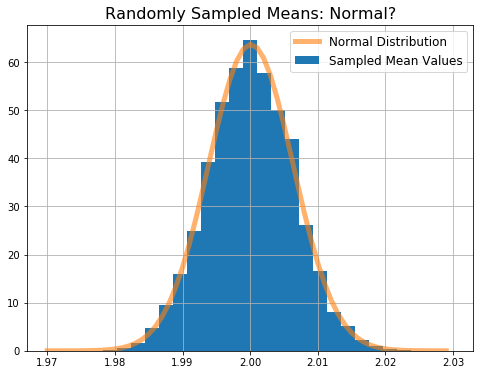

In [5]:
plt.figure(figsize=(8,6));

#Plot the sampled means
binmin, binmax, nbins = 1.97, 2.03, 30
plt.hist(means,bins=np.linspace(binmin,binmax,nbins),normed=True,\
         label='Sampled Mean Values');

#Plot a normal distribution on top for visual comparison
xvals = np.arange(binmin, binmax, 0.001)
plt.plot(xvals, norm.pdf(xvals,np.mean(means),np.std(means)),\
         linewidth=5,alpha=0.6,label='Normal Distribution')

#Misc plot options
plt.title('Randomly Sampled Means: Normal?',fontsize=16);
plt.legend(fontsize=12);
plt.grid(True);

That took me maybe five minutes to do (including testing with a few different input distributions), and now I've at least convinced myself that the CLT is sometimes true. **Of course there are always caveats to be aware of when looking at a few positive examples and blindly believing a fundamental theorem like the CLT, but in this case I've quickly demonstrated to myself that it at least sometimes works.**

### Example 2: Throwing Darts for $\pi$

The very first programming problem I ever solved was to estimate the value of $\pi$ using only a random number generator. The reason I got assigned this was to learn a new programming language (C++), _not_ to compute a precise value for $\pi$... If you want to do that, there are far more efficient methods than this. 

One way to solve this problem is to imagine a circle inscribed within a unit square. You throw darts at the square, and count how many land inside the circle. The ratio of darts within the circle to total darts thrown should be equal to the ratio of the circle's area to the squares area. In this case, the circle's radius is $\frac{1}{2}$ and the square's area is 1, so that ratio should be $\frac{\pi}{4}$. Compute the ratio, multiply by four, and you should have $\pi$!

Here's a really nice gif I found that demonstrates graphically what's going on in this example [[source]](http://www.thephysicsmill.com/2014/05/03/throwing-darts-pi/).

![test](images/monte_carlo_for_pi.gif.png)


In [6]:
#Throw darts at the square! 
#For each dart, compute a random (x,y) coordinate within the unit square.
N_throws = int(1e6)
throw_coords = np.random.random_sample(size=(N_throws,2))

#For each throw, compute the euclidean distance to the circle's center at (0.5, 0.5).
#If the distance is less than the circle's radius, it is inside the circle.
def dist(coord): return np.sqrt(np.square(coord[0]-0.5) + np.square(coord[1]-0.5))

N_in_circle = 0
for throw_coord in throw_coords:
    if dist(throw_coord) <= 0.5: N_in_circle += 1
        
pi_estimate = 4 * float(N_in_circle)/float(N_throws)

In [7]:
print pi_estimate

3.140232


### Example 3: Boy/Girl Population Estimate for Biased Parents

I found this example after googling something like "Data Scientist interview questions". While there's definitely a way to solve this problem with logic, I prefer the easy method: throwing darts.

The question is: 
> _In a city where residents prefer only boys, every family in the city continues to give birth to children until a boy is born. If a girl is born, they plan for another child. If a boy is born, they stop. Find out the proportion of boys to girls in the city._



We'll solve this by simulating a parent having a child, then randomly deciding if that child is a boy or a girl. They continue having children until one of them is a boy. We keep track of the total number of each gender of child, and compare them to get our final answer.

In [8]:
def run_boygirl_sim(N_parents = 10000):
    #true == boy, false == girl
    parents = range(N_parents)
    total_kids = []
    for parent in parents:
        while(True):
            isboy = bool(random.getrandbits(1))
            total_kids.append(isboy)
            if isboy: break
    nboys = np.sum(total_kids)
    ngirls = len(total_kids) - nboys
    
    return float(nboys) / ngirls

In [9]:
#run the simulation 1000 times, each with 10k parents
boygirl_proportions = [run_boygirl_sim() for x in range(1000)]

In [10]:
print "Proportion of boys to girls: %f, std %0.4f." % \
    (np.mean(boygirl_proportions),np.std(boygirl_proportions))

Proportion of boys to girls: 0.998950, std 0.0142.


[The math stack exchange agrees with the results; there are an equal number of boys and girls in the city.](https://math.stackexchange.com/questions/20426/famous-puzzle-girl-boy-proportion-problem-sum-of-infinite-series) This is one of those problems where (to me, anyway) the answer is non-obvious... but, I trust my simulation to yield the correct solution!

### Example 4: Average Distance to the Airport
OK, so those were some pretty simple problems. What about a more complicated problem that can't actually be rigously solved? Let's try to compute the average distance a person would have to drive to OHare airport from a random address inside of Chicago. 

I came up with this off the top of my head, but it could have some practical applications for taxi drivers, etc. You could also reframe this problem as "what location inside of Chicago has the shortest average distance to all other places inside of Chicago?" which might be useful in determining, for example, the optimal location of a future emergency room.

To begin, I downloaded the [city of chicago boundary shapefile](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-City/ewy2-6yfk) and converted it to a shapely polygon.

In [11]:
my_poly = gpd.read_file('data/ChicagoShapefile/shpfile.shp').geometry.values[0]

In [12]:
#ignore
#convert multipolygon into polygon
eps = 0.01
my_poly = cascaded_union([
    Polygon(component.exterior).buffer(eps).buffer(-eps) for component in my_poly
])

In [13]:
#According to google maps, this is about where OHare airport is.
ohare_latlon = 41.978884, -87.902600

In [14]:
plt.figure(figsize=(6,10))
plt.plot(*my_poly.exterior.xy,color='g',linewidth=10)
plt.plot(ohare_latlon[1], ohare_latlon[0],'ro',markersize=20)
mplleaflet.display()

Now we choose some random points within the city by throwing darts at it. To accomplish this, I use [this technique](https://gis.stackexchange.com/questions/207731/how-to-generate-random-coordinates-in-a-multipolygon-in-python) from stack overflow.

In [15]:
def generate_random_inpoly(number, polygon):
    list_of_points = []
    minx, miny, maxx, maxy = polygon.bounds
    counter = 0
    while counter < number:
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(pnt):
            list_of_points.append(pnt)
            counter += 1
    return list_of_points

In [16]:
#ignore
#converting lat, long to approximate distance in kilometers
def haversine_dist(latlong1, latlong2):
    lat1, lon1, lat2, lon2 = latlong1[0], latlong1[1], latlong2[0], latlong2[1]
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    Rearth = 6371. # earth radius, kilometers
    x = (lon2 - lon1) * np.cos( 0.5*(lat1 + lat2))
    y = lat2 - lat1
    return Rearth * np.sqrt( x*x + y*y )

In [17]:
#generate 1000 points which are within the polygon
polypoints = generate_random_inpoly(1000,my_poly)

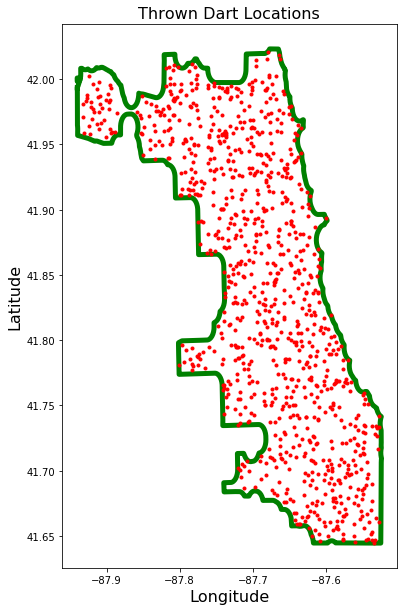

In [18]:
plt.figure(figsize=(6,10))
plt.plot(*my_poly.exterior.xy,color='g',linewidth=5)
for polypoint in polypoints:
    plt.plot(polypoint.x,polypoint.y,'r.')
plt.title('Thrown Dart Locations',fontsize=16)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16);

Now we compute the straight line distance in kilometers from each point to OHare using the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula).

In [19]:
ohare_dists = [haversine_dist((dk.y,dk.x),ohare_latlon) for dk in polypoints]

In [20]:
print 'Mean distance from random point in Chicago to OHare: %0.2f km (%0.2f std)' % \
 (np.mean(ohare_dists),np.std(ohare_dists))

Mean distance from random point in Chicago to OHare: 24.85 km (11.60 std)


It turns out the average distance from an arbirary point in Chicago to OHare is about 25 kilometers!

Keep in mind that's a straight line distance; to apply this more directly to a taxi-type problem, I would recommend using something like [osrm](http://project-osrm.org/) to compute the average _driving route distance_ instead of straight-line. To apply this more directly to an emergency room location optimization type problem, I would weight each dart throw based on the population density in the neighborhood around that dart. These improvements are beyond the scope of this blog post, but aren't terribly difficult to do.

### Example 5: That Can't Be Right ...
For one last example, I'll share a problem that I used MC to verify the answer to. I found this problem online and didn't believe the solution they gave... so, I simulated it and found that it is indeed correct. I'm not sure I completely understand it, but [simulations don't lie](https://www.youtube.com/watch?v=DUT5rEU6pqM) (if you do them right!), so I believe it now.

Here's the problem: 
> _Choose, at random, three points on the circle $x^2 + y^2 = 1$. Interpret them as cuts that divide the circle into three arcs. Compute the expected length of the arc that contains the point (1, 0)._



Spoiler alert: apparently the answer is $\pi$, not $\frac{2\pi}{3}$, because "the arc containing (1,0) is likely to be larger than the others". I still need to think about this one...

In [21]:
results = []
for x in range(100000):
    #3 random numbers between 0 and 2pi, represent degrees clockwise around the circle, 
    #starting at (1,0). Order them from small to high, so the first point in the list 
    #is the first point below (1,0) clockwise and the third point in the list is the 
    #last point before returning to (1,0) clockwise
    cps = sorted(np.random.random_sample(size=3)*2*np.pi)
    #compute the length of each arc
    arclens = [cps[1] - cps[0], cps[2] - cps[1], cps[0] - cps[2] + 2*np.pi]
    #because of the sorting, the third arc is always the one that contains the point (0,1)
    results.append(arclens[2])

In [22]:
print "Mean length of the arc containing (0,1):",np.mean(results)

Mean length of the arc containing (0,1): 3.137949551220017


I hope that you found this post interesting, and that it has inspired you to start throwing darts at work (but not at your coworkers). Using Monte Carlo to answer every day questions is an under-utilized technique from which I think the Data Science community could benefit greatly. 

P.S. If you can explain to me why the solution to example 5 isn't $\frac{2\pi}{3}$, or if you have any thoughts about this blog post, you can let me know in the comments below!